In [13]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
from copy import deepcopy
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from model_fitting import initialize_fitting
from utils import roi_utils, nsd_utils


In [36]:
device = torch.device('cpu:0')

In [14]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX 1080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [15]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
# Load results of the fitting procedure

subject = 1
n_from_end = 0; # if zero, load most recent; if positive, load second most recent etc.

fitting_type = 'bdcn_pca_fused'

root = os.path.dirname(os.path.dirname(os.getcwd()))
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1-n_from_end]

# most_recent_date = 'Jul-06-2021_0356'

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

fig_save_folder = os.path.join(root,'figures','S%02d'%subject, fitting_type, most_recent_date)

loading from /user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-28-2021_1909/all_fit_params

dict_keys(['aperture', 'aperture_rf_range', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'pc', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'zscore_features', 'n_prf_sd_out', 'debug', 'up_to_sess', 'shuff_rnd_seed'])


In [159]:
# sd = 1, no mult, no ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0330_07/'
# sd = 1, no mult, ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0358_49/'

# sd = 2, no mult, no ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0431_02/'
# sd = 2, no mult, ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0534_22/'

# sd = 1, mult, no ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0641_13/'
# sd = 1, mult, ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0709_00/'

# sd = 2, mult, no ridge
path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0704_19/'
# sd = 2, mult, ridge
# path = '/user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Aug-30-2021_0807_16/'

out = torch.load(os.path.join(path,'all_fit_params'))


print('n_sd_out = %d'%out['n_prf_sd_out'])
print('mult_patch_by_prf = %s'%out['mult_patch_by_prf'])
print('ridge = %s'%out['ridge'])

fig_save_folder
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

out.keys()

# Pulling out useful elements from the saved data

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index'][0]
voxel_ncsnr = out['voxel_ncsnr'].ravel()[voxel_idx]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)

best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

val_cc = out['val_cc'][:,0]
# Note i'm NOT using the thing that actually is in the field val_r2, 
# bc that is coefficient of determination which gives poor results for ridge regression.
# instead using the signed squared correlation coefficient for r2/var explained.
val_r2 = np.sign(val_cc)*val_cc**2

best_params = out['best_params']
best_models, weights, bias, features_mt, features_st, best_model_inds = best_params
pct_var_expl, min_pct_var, n_comp_needed = out['pc']

best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

n_voxels = np.shape(weights)[0]

zscore_features = out['zscore_features']
print('zscore_features=%s\n'%zscore_features)
n_prf_sd_out = out['n_prf_sd_out']
models = out['models']

print('Shape of best weights matrix:')
print(np.shape(weights))


n_sd_out = 2
mult_patch_by_prf = True
ridge = False
zscore_features=True

Shape of best weights matrix:
(14913, 401)


In [160]:
# Set up the pRFs to test
from utils import texture_utils
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

image_size = [227,227]
n_features = np.zeros(shape=(len(models),),dtype=int)
for mm in range(len(models)):
    bbox = texture_utils.get_bbox_from_prf(models[mm], image_size)
    n_features[mm] =  (bbox[1] - bbox[0]) * (bbox[3] - bbox[2])
max_features = np.max(n_features)

print(np.unique(n_features[best_model_inds]))

print(np.unique(best_models[:,2]))

# Gather labels for all ROIs

voxel_roi = out['voxel_roi']
if len(voxel_roi)==2:
    [roi_labels_retino, roi_labels_categ] = deepcopy(voxel_roi)
    roi_labels_retino = roi_labels_retino[voxel_idx]
    roi_labels_categ = roi_labels_categ[voxel_idx]

nsd_root, stim_root, beta_root, mask_root = initialize_fitting.get_paths()
ret, face, place = roi_utils.load_roi_label_mapping(nsd_root, subject, verbose=True)
max_ret_label = np.max(ret[0])
face[0] = face[0]+max_ret_label
max_face_label = np.max(face[0])
place[0] = place[0]+max_face_label
print(face)
print(place)
print(np.unique(roi_labels_categ))

ret_group_names = roi_utils.ret_group_names
ret_group_inds =  roi_utils.ret_group_inds
n_rois_ret = len(ret_group_names)

categ_group_names = list(np.concatenate((face[1], place[1])))
categ_group_inds =  list(np.concatenate((face[0], place[0])))
n_rois_categ = len(categ_group_names)

n_rois = n_rois_ret + n_rois_categ

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]
[ 168  272  312  441  714  819 1156 1326 1521]
[0.04]
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']
[1, 2, 3, 4, 5]
['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
[1, 2, 3]
['OPA', 'PPA', 'RSC']
[array([26, 27, 28, 29, 30]), ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']]
[array([31, 32, 33]), ['OPA', 'PPA', 'RSC']]
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]


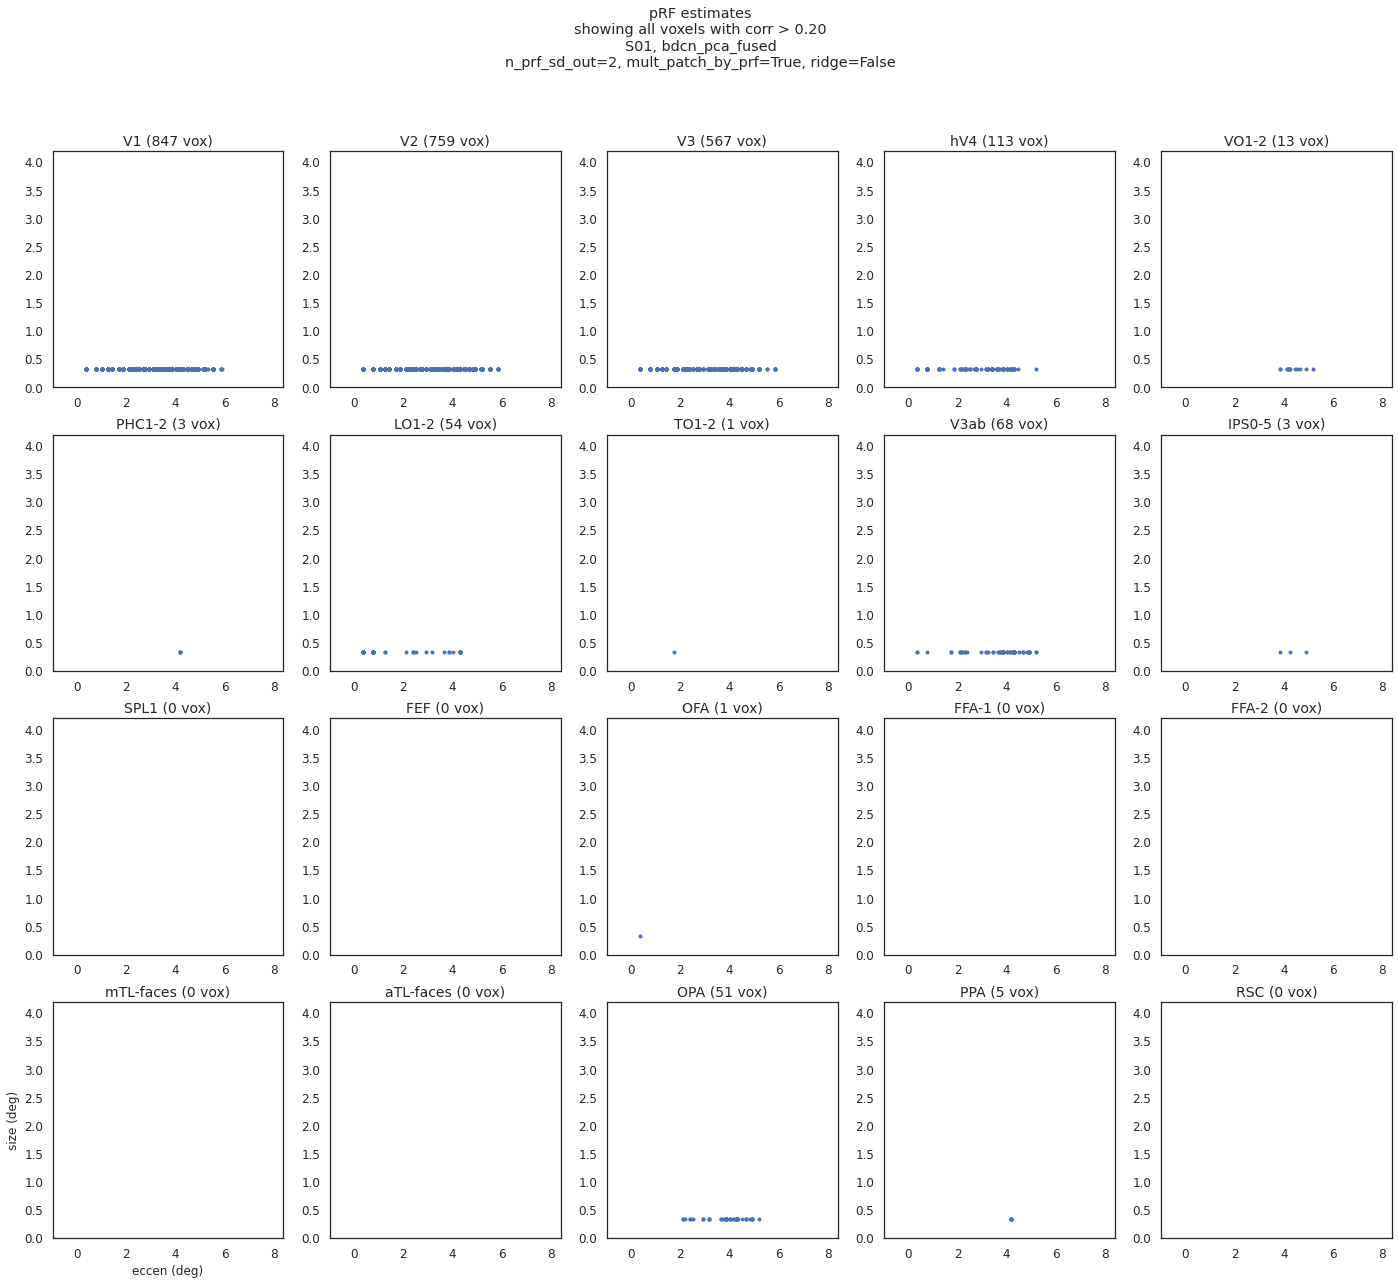

In [161]:
# Plot spatial RF estimates
import matplotlib


eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

size_lims = eccen_deg*np.array([0, 0.5])
eccen_lims = [-1, eccen_deg]

plt.figure(figsize=(24,20))

cc_cutoff = 0.20
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
           
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()
    
    eccen_values = np.sqrt(best_models_deg[inds2use,0]**2+ best_models_deg[inds2use,1]**2)
    plt.plot(eccen_values, best_models_deg[inds2use,2], '.')

    plt.xlim(eccen_lims)
    plt.ylim(size_lims)
    if rr==n_rois-5:
        plt.xlabel('eccen (deg)')
        plt.ylabel('size (deg)')
#     else:
#         plt.xticks([])
#         plt.yticks([])
    plt.title('%s (%d vox)'%(rname, len(inds2use)))

#     plt.axis('equal')
plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s\nn_prf_sd_out=%d, mult_patch_by_prf=%s, ridge=%s'%(cc_cutoff, subject, fitting_type, out['n_prf_sd_out'], out['mult_patch_by_prf'],out['ridge']));

# plt.savefig(os.path.join(fig_save_folder,'size_vs_eccen.pdf'))
# plt.savefig(os.path.join(fig_save_folder,'size_vs_eccen.png'))

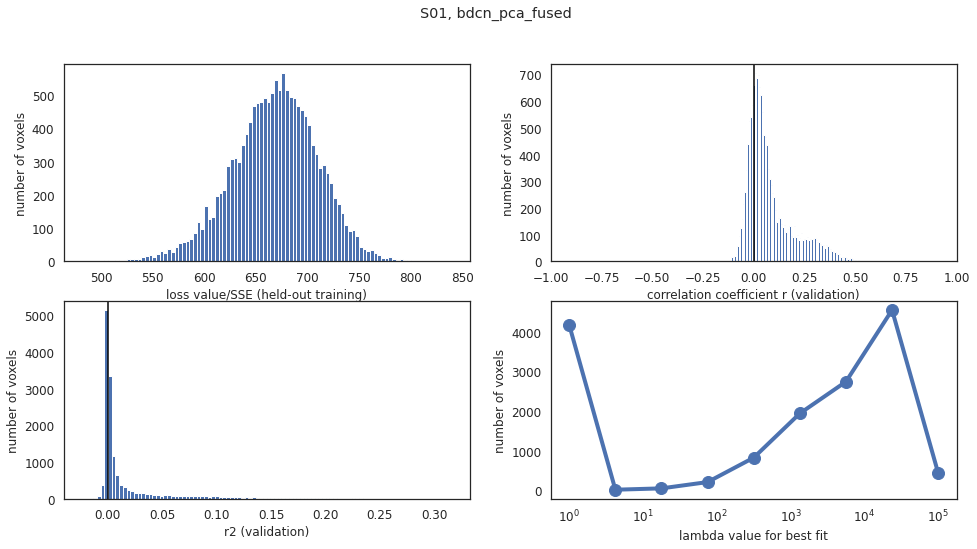

In [117]:
# Plot summary of performance

cclims = [-1,1]
# losslims = [20,120]
losslims = [350,850]
plt.figure(figsize=(16,8));

plt.subplot(2,2,1)
plt.hist(best_losses,100)
# plt.xlim(losslims)
# plt.xlim([500,2000])
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');

plt.subplot(2,2,2)
plt.hist(val_cc,100)
# plt.hist(val_cc,100)
# plt.xlim([-0.2, 0.8])
plt.xlim(cclims)
plt.xlabel('correlation coefficient r (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(2,2,3)

# plt.hist(np.sign(val_cc)*val_cc**2,100)
plt.hist(val_r2,100)
# plt.xlim([-0.2, 0.8])
plt.xlabel('r2 (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(2,2,4)

plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');


plt.suptitle('S%02d, %s'%(subject, fitting_type))
plt.savefig(os.path.join(fig_save_folder,'fit_summary.png'))
plt.savefig(os.path.join(fig_save_folder,'fit_summary.pdf'))

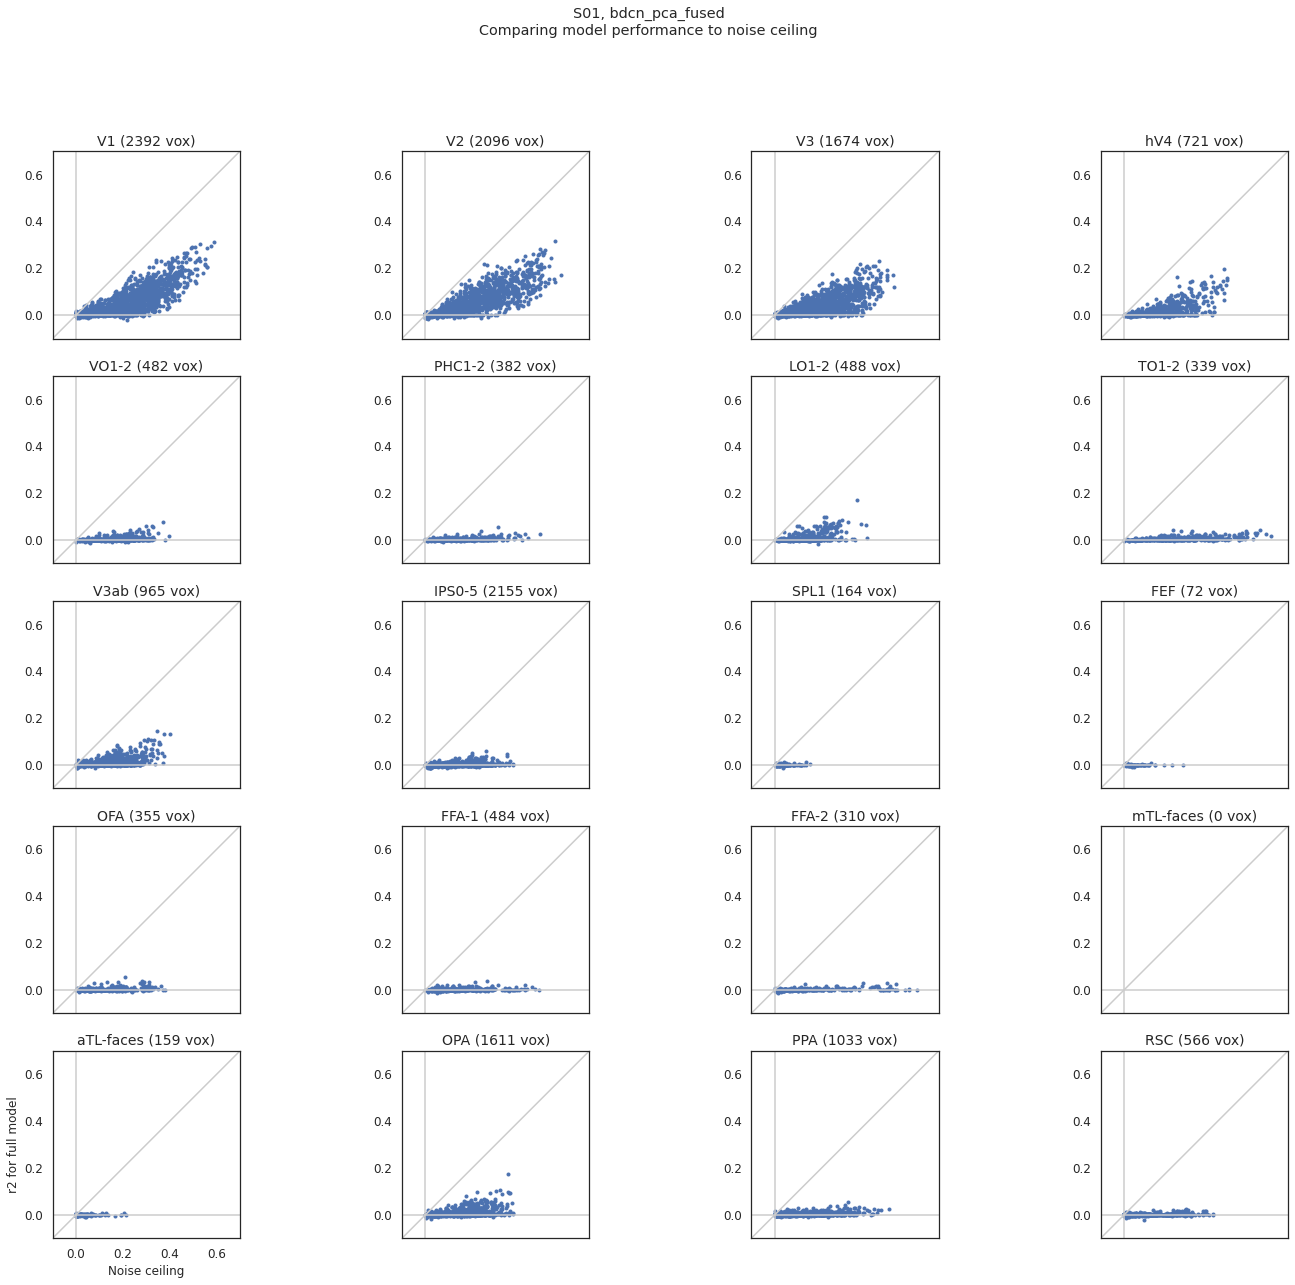

In [118]:
# Scatter plot comparing model prediction to noise ceiling

plt.figure(figsize=(24,20))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

# colors = cm.plasma(np.linspace(0,1,1))
# colors = np.flipud(colors)

cc_cutoff = -100

xlims = [-0.1, 0.7]
ylims = [-0.1, 0.7]

for rr in range(n_rois):
# for rr in range(1):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
   
    if np.sum(inds2use)>0:
        
        xvals = noise_ceiling[inds2use]/100
        yvals = val_r2[inds2use]

        plt.plot(xvals,yvals,'.')
#         plt.plot(xvals,yvals,'.',color = [0.4, 0.4, 0.4])
#         xvals = xvals[yvals>0.2**2]
#         yvals = yvals[yvals>0.2**2]
#         plt.plot(xvals,yvals,'.',color = 'b')

    if rr==n_rois-4:
        plt.xlabel('Noise ceiling')
        plt.ylabel('r2 for full model')
    else:
        plt.xticks([])
    plt.axis('square')

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.plot(xlims, ylims, color=[0.8, 0.8, 0.8])
    plt.axvline(color=[0.8, 0.8, 0.8])
    plt.axhline(color=[0.8, 0.8, 0.8])
    
    
    plt.title('%s (%d vox)'%(rname, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type))

plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.png'))
plt.savefig(os.path.join(fig_save_folder,'r2_vs_noiseceiling.pdf'))

In [21]:
val_cc

array([-0.06655695, -0.03068899,  0.04848672, ..., -0.05799996,
       -0.02600727,  0.01851951], dtype=float32)

Text(0.5, 0.98, 'S01, bdcn_pca_fused')

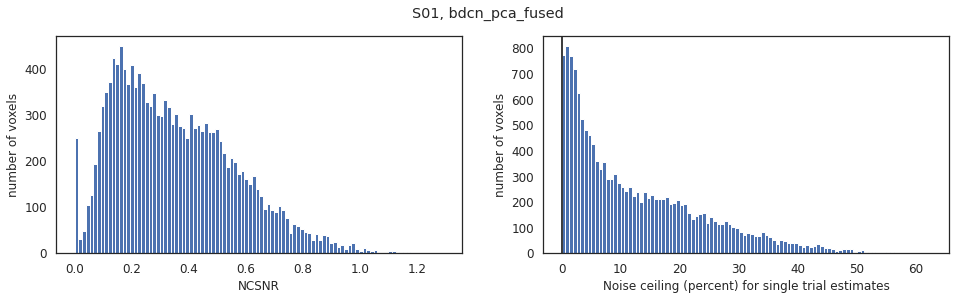

In [65]:
# Plot noise ceiling

plt.figure(figsize=(16,4));

plt.subplot(1,2,1)
plt.hist(voxel_ncsnr,100)
plt.xlabel('NCSNR');
plt.ylabel('number of voxels');

plt.subplot(1,2,2)
plt.hist(noise_ceiling,100)
plt.xlabel('Noise ceiling (percent) for single trial estimates');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


plt.suptitle('S%02d, %s'%(subject, fitting_type))

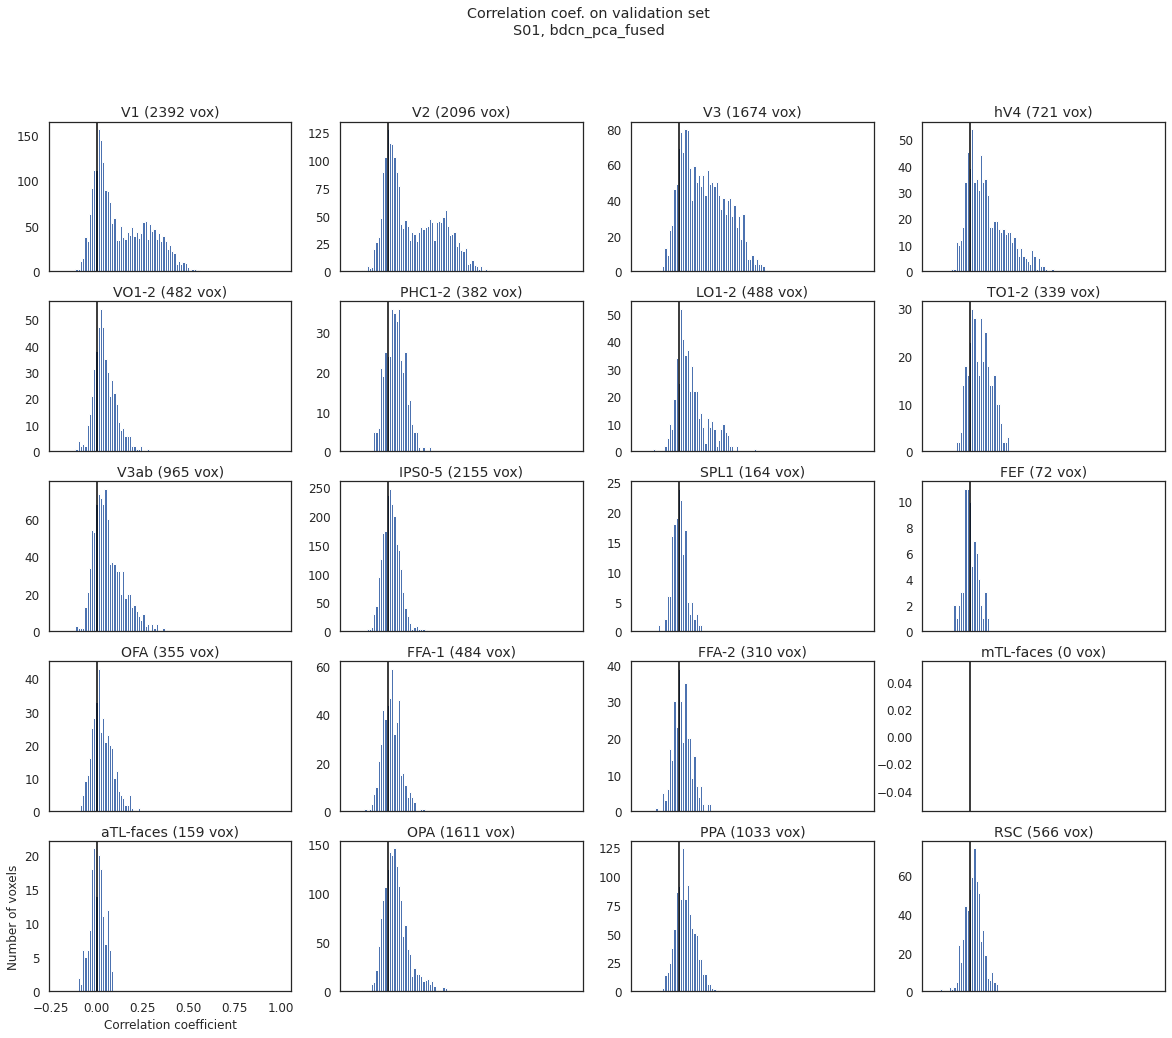

In [119]:
# Plot correlation coefficient for each ROI separately.

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
        
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-4:
        plt.xlabel('Correlation coefficient')
        plt.ylabel('Number of voxels')
    else:
        plt.xticks([]);
#         plt.yticks([])
        
    plt.axvline(0,color='k')

    plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d, %s'%(subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'corr_each_roi.pdf'))
plt.savefig(os.path.join(fig_save_folder,'corr_each_roi.png'))

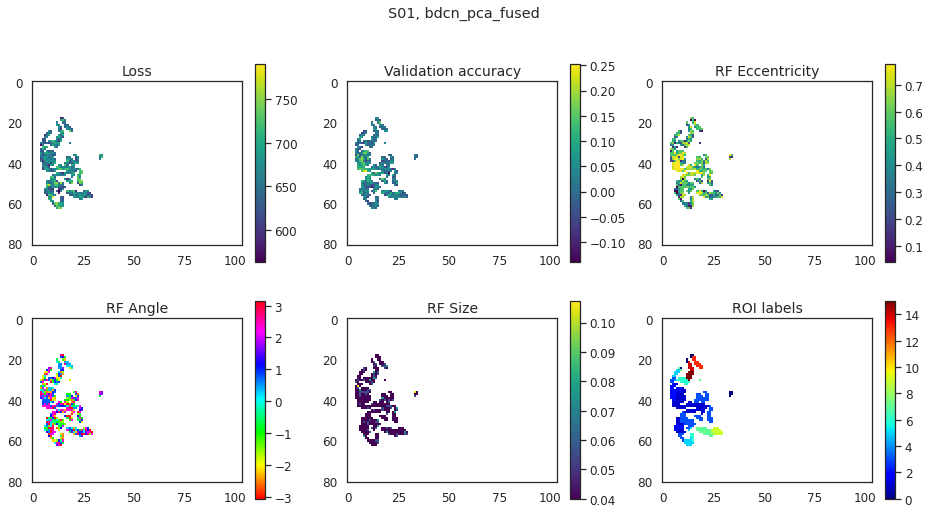

In [36]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

sys.path.append(os.path.join(root,'code'))
from utils import file_utility

volume_loss = file_utility.view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = file_utility.view_data(brain_nii_shape, voxel_idx, val_cc)
volume_ecc  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ecc)
volume_ang  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ang)
volume_size = file_utility.view_data(brain_nii_shape, voxel_idx, best_size)
volume_roi = file_utility.view_data(brain_nii_shape, voxel_idx, roi_labels_retino)

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='viridis', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

plt.suptitle('S%02d, %s'%(subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'fit_summary_volumespace.pdf'))
plt.savefig(os.path.join(fig_save_folder,'fit_summary_volumespace.png'))

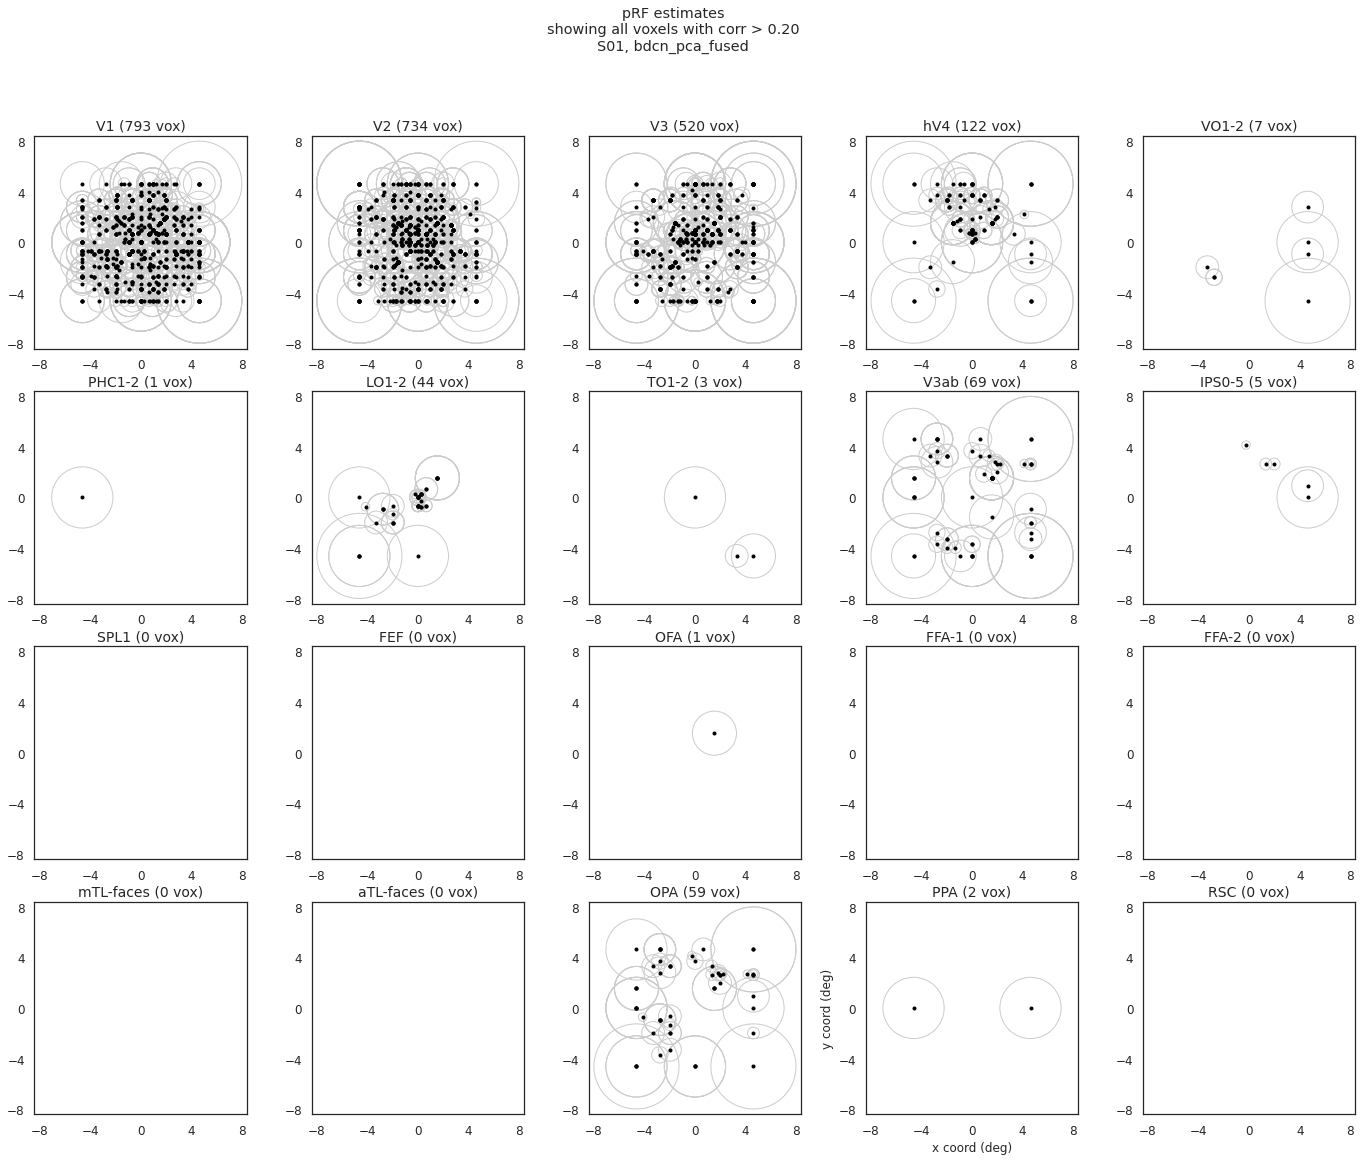

In [120]:
# Plot spatial RF estimates
import matplotlib

eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

plt.figure(figsize=(24,18))

cc_cutoff = 0.20
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npx))

for rr in range(n_rois):
        
    if rr<n_rois_ret:
        inds_this_roi = np.isin(roi_labels_retino, ret_group_inds[rr])
        rname = ret_group_names[rr]
    else:
        inds_this_roi = np.isin(roi_labels_categ, categ_group_inds[rr-n_rois_ret])
        rname = categ_group_names[rr-n_rois_ret]
           
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()

    for vi, vidx in enumerate(inds2use):
       
        plt.plot(best_models_deg[vidx,0], best_models_deg[vidx,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_deg[vidx,0], best_models_deg[vidx,1]), best_models_deg[vidx,2], color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if rr==n_rois-2:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    plt.title('%s (%d vox)'%(rname, len(inds2use)))

plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s'%(cc_cutoff, subject, fitting_type));

plt.savefig(os.path.join(fig_save_folder,'spatial_prf_distrib.pdf'))
plt.savefig(os.path.join(fig_save_folder,'spatial_prf_distrib.png'))

In [126]:
best_models_deg[vidx,2]

2.418143963813782

In [ ]:
bes

In [29]:
best_models[:,2]

array([0.05557982, 0.04      , 0.05557982, ..., 0.04      , 0.07722791,
       0.05557982])

In [88]:
best_model_inds

array([ 32, 372, 350, ..., 169, 268,  35])

['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']


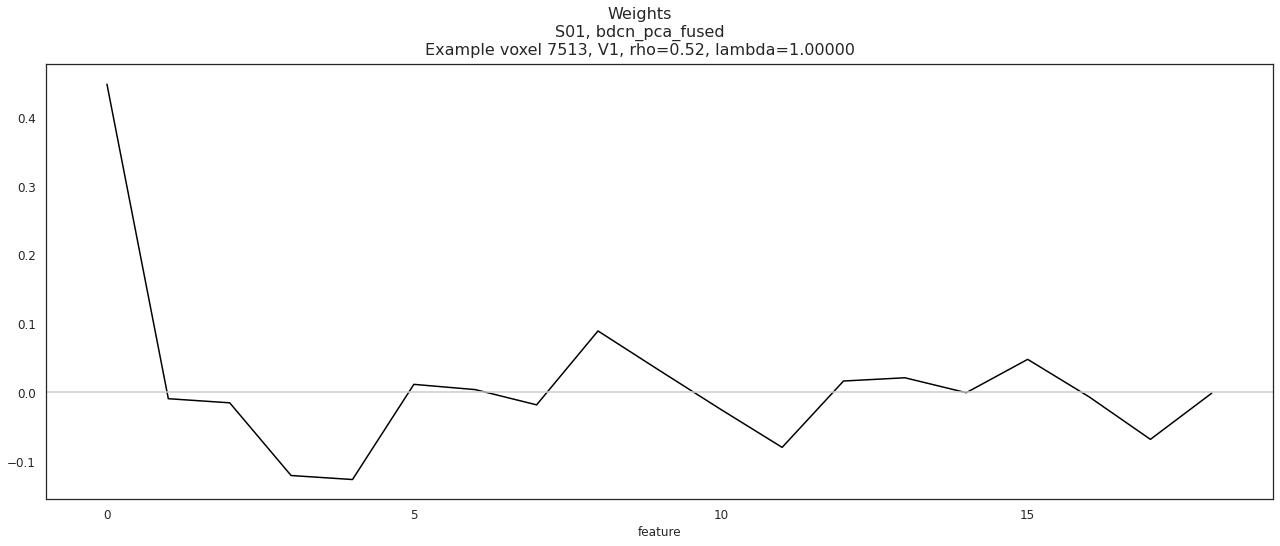

In [78]:
# Plotting weights for all features, choosing one voxel at a time.

from copy import deepcopy

pp=0

vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
# vox2plot = 929

colors = cm.plasma(np.linspace(0,1,n_feature_types))
colors = np.flipud(colors)
# vox2plot = np.random.randint(0,len(val_cc),1)

vv=vox2plot

nc = n_comp_needed[best_model_inds[vv]]

plt.figure(figsize=(22,8))

wts = weights[vv,0:nc]
plt.plot(wts,'-',color='k')

plt.axhline(0,color=[0.8, 0.8, 0.8])
# if vi==(npx-1)*npy:
plt.xlabel('feature')
#     plt.ylabel('weight')
# else:
#     plt.xticks([]); 
#     plt.yticks([])

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())
plt.xlim([-1, nc]);
plt.xticks(np.arange(0,nc,5))

plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
